# 15. InceptionV3

Весь код взят из [Каггла](https://www.kaggle.com/code/romankovalenko/inception-v3-pytorch-implementation), спасибо автору Роману Коваленко

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from time import time
from IPython.display import clear_output

from torchmetrics import F1Score, Accuracy
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

from typing import List, Dict, Any

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# https://github.com/Harry24k/Pytorch-Basic/blob/master/Week5/20.%20Transfer%20Learning%20with%20Inception%20v3.ipynb
# https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Utils

In [2]:
def undo_normalize(image: torch.Tensor, mean: List[float], std: List[float]) -> np.array:
    # Undo the normalization from single image
    # return numpy array with image order dim     
    
    for channel, (mean_val, std_val) in enumerate(zip(mean, std)):
        image[channel] = (image[channel] * std_val) + mean_val
    image = torch.clamp(image, 0, 1)
    return image.numpy().transpose((1, 2, 0))

In [3]:
def show_random_images(batch: torch.Tensor, labels: List[int], class_names: Dict, num_images=5):
    # Show images from batch   
    
    indices = np.random.choice(len(batch), num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i, ax in enumerate(axes):
        idx = indices[i]
        image = batch[idx].clone() 
        image = undo_normalize(image, MEAN, STD)
        
        label = labels[idx].item()
        class_name = class_names[label]
        
        ax.imshow(image)
        ax.set_title(class_name)
        ax.axis('off')

    plt.show()

### Metrics

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
f1_score = F1Score(task="multiclass", num_classes=6).to(device)
accuracy_score = Accuracy(task="multiclass", num_classes=6).to(device)

In [6]:
def calculate_metrics(dataloader_test, model):
    avg_f1 = 0
    avg_acc = 0
    model.eval()
    with torch.no_grad():
        for X_batch, Y_batch in dataloader_test:
            inputs = X_batch.to(device)
            labels = Y_batch.to(device)

            outputs = model(inputs)
            cur_f1 = f1_score(torch.argmax(outputs.detach(), dim=1), labels)
            cur_accuracy = accuracy_score(torch.argmax(outputs.detach(), dim=1), labels)

            avg_f1 += cur_f1/ len(dataloader_test)
            avg_acc += cur_accuracy/ len(dataloader_test)
    return avg_f1, avg_acc

In [7]:
def train(model, opt, loss_fn, epochs, dataloader_tr, dataloader_val):
    history = {"epochs": np.arange(epochs)+1, 
               "train": {"score_f1": [], "score_acc": [], "loss": []},  
               "val":   {"score_f1": [], "score_acc": [], "loss": []}}

    def _train_epoch():
        avg_loss = 0
        avg_f1 = 0
        avg_acc = 0
        model.train()  # train mode
        for X_batch, Y_batch in dataloader_tr:
            # data to device
            inputs = X_batch.to(device)
            labels = Y_batch.to(device)
            
            # set parameter gradients to zero
            opt.zero_grad()
            
            # forward
            outputs = model(inputs)
            # forward-pass
            loss = loss_fn(outputs, labels)
            # backward-pass
            loss.backward()
            # update weights
            opt.step()
                         
            cur_f1 = f1_score(torch.argmax(outputs.detach(), dim=1), labels)
            cur_accuracy = accuracy_score(torch.argmax(outputs.detach(), dim=1), labels)

            # calculate loss to show the user
            avg_loss += loss / len(dataloader_tr)
            avg_f1 += cur_f1/ len(dataloader_tr)
            avg_acc += cur_accuracy/ len(dataloader_tr)
        return avg_loss, avg_f1, avg_acc
        
    def _validate_epoch():
        avg_loss = 0
        avg_f1 = 0
        avg_acc = 0
        model.eval()
        with torch.no_grad():
            for X_batch, Y_batch in dataloader_val:
                inputs = X_batch.to(device)
                labels = Y_batch.to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                cur_f1 = f1_score(torch.argmax(outputs.detach(), dim=1), labels)
                cur_accuracy = accuracy_score(torch.argmax(outputs.detach(), dim=1), labels)

                avg_loss += loss / len(dataloader_val)
                avg_f1 += cur_f1/ len(dataloader_val)
                avg_acc += cur_accuracy/ len(dataloader_val)
        return avg_loss, avg_f1, avg_acc
    
   
    for epoch in range(epochs):
        clear_output(wait=True)
        print('* Epoch %d/%d' % (epoch+1, epochs))
        tic = time()
        avg_loss, avg_f1, avg_acc = _train_epoch()
        toc = time()

        avg_loss_val, avg_f1_val, avg_acc_val = _validate_epoch()

        print(f'loss: {avg_loss:.3f}, f1: {avg_f1:.3f}, accuracy: {avg_acc:.3f}, time {(toc - tic):.3f}')
        print(f'vall loss: {avg_loss_val:.3f}, vall f1: {avg_f1_val:.3f}, vall accuracy: {avg_acc_val:.3f}')
        
        
        history["train"]["loss"].append(avg_loss.item())
        history["val"]["loss"].append(avg_loss_val.item())
        
        history["train"]["score_f1"].append(avg_f1.item())
        history["val"]["score_f1"].append(avg_f1_val.item())
        
        history["train"]["score_acc"].append(avg_acc.item())
        history["val"]["score_acc"].append(avg_acc_val.item())

    torch.cuda.empty_cache()
    return history

# Dataset and DataLoader

In [8]:
class IntelImageDataset(Dataset):
    def __init__(self, data_dir: str, portion = 1.0, transform=None):
        self.data_dir = data_dir
        self.classes = os.listdir(self.data_dir)
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}
        self.transform = transform
        self.images = []
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.images.append((os.path.join(class_dir, image_name), class_name))
        
        if portion < 1.0:
            indices = np.random.choice(len(self.images), int(portion * len(self.images)), replace=False)
            result = [self.images[i] for i in indices]
            self.images = result 
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path, image_class_name = self.images[idx]
        image = read_image(image_path)
        image_class_id = self.class_to_idx[image_class_name]
        if self.transform:
            image = self.transform(image)
        return image, image_class_id

In [9]:
transform = transforms.Compose([
    transforms.Resize((299, 299),interpolation=transforms.InterpolationMode.BICUBIC, antialias=False),
    transforms.ConvertImageDtype(dtype=torch.float),
    transforms.Normalize(mean=MEAN, std=STD), 
    ])

full_dataset = IntelImageDataset(data_dir='/kaggle/input/intel-image-classification/seg_train/seg_train', transform=transform, portion=1.0)

# train_size = int(0.8 * len(full_dataset))
# validate_size = len(full_dataset) - train_size
# train_dataset, validate_dataset = torch.utils.data.random_split(full_dataset, [train_size, validate_size], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(full_dataset, batch_size=32, shuffle=True)
# valid_dataloader = DataLoader(validate_dataset, batch_size=32, shuffle=True)

test_dataset = IntelImageDataset(data_dir='/kaggle/input/intel-image-classification/seg_test/seg_test', transform=transform, portion=1.0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f'Train data len: {len(full_dataset)}')
# print(f'Validate data len: {len(validate_dataset)}')
print(f'Test data len: {len(test_dataset)}')

Train data len: 14034
Test data len: 3000


# Demonstration of some images

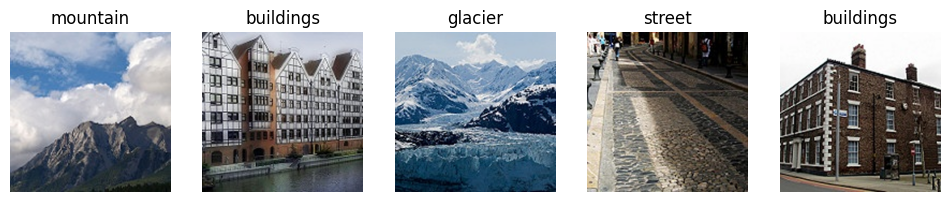

In [10]:
first_train_batch = next(iter(train_dataloader))
show_random_images(first_train_batch[0], first_train_batch[1], full_dataset.classes)

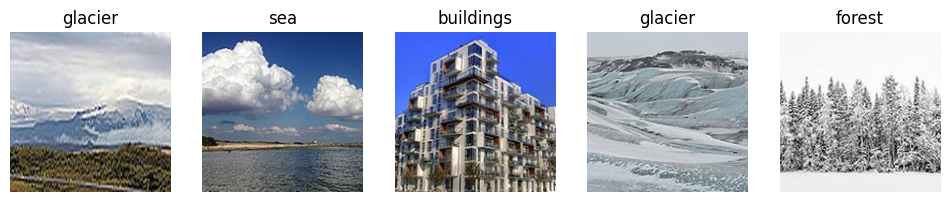

In [11]:
first_test_batch = next(iter(test_dataloader))
show_random_images(first_test_batch[0], first_test_batch[1], full_dataset.classes)

# Inception v3 

Inception v3 is an image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. The model is the culmination of many ideas developed by multiple researchers over the years. It is based on the original paper: ["Rethinking the Inception Architecture for Computer Vision" by Szegedy, et. al.](https://arxiv.org/abs/1512.00567) 

A high-level diagram of the model is shown in the following screenshot:

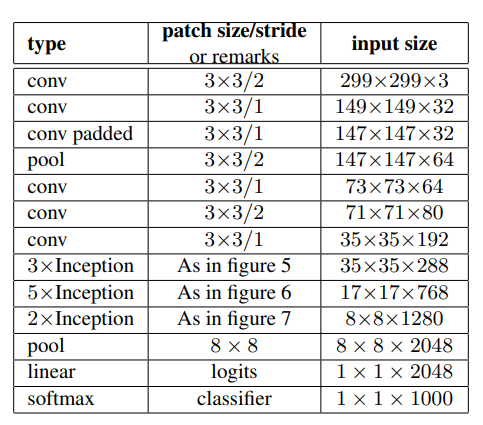
> **Table 1.** The outline of the proposed network architecture. The output size of each module is the input size of the next one. We are using variations of reduction technique depicted Figure 10 to reduce the grid sizes between the Inception blocks whenever applicable. We have marked the convolution with 0-padding, which is used to maintain the grid size. 0-padding is also used inside those Inception modules that do not reduce the grid size. All other layers do not use padding. The various filter bank sizes are chosen to observe principle 4 from Section 2.


# Parts of the convolutional network

## Basic convolution layer

In [12]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, padding_mode='replicate', **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.actv = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.actv(x)
        return x

## Inception Block "A"


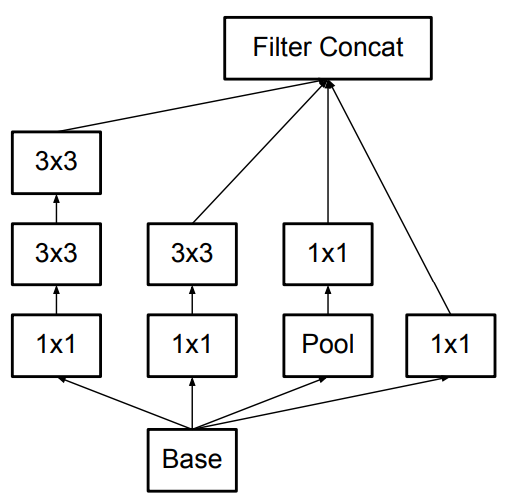
> **Figure 5.** Inception modules where each 5 × 5 convolution is replaced by two 3 × 3 convolution, as suggested by principle 3 of Section 2.

In [13]:
class InceptionBlock_A(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.sub_layer_1 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=32, kernel_size=1, stride=1, padding=0),
            BasicConv2d(in_channels=32,          out_channels=64, kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels=64,          out_channels=80, kernel_size=3, stride=1, padding=1),
        )
        self.sub_layer_2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1, padding=0),
            BasicConv2d(in_channels=64,          out_channels=80, kernel_size=3, stride=1, padding=1),
        )
        self.sub_layer_3 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1, padding=0),
        )
        self.sub_layer_4 = \
            BasicConv2d(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        outputs = [
            self.sub_layer_1(x),
            self.sub_layer_2(x),
            self.sub_layer_3(x),
            self.sub_layer_4(x)
        ]

        return torch.cat(outputs, 1)
    
    
# rnd = torch.rand(1, 288, 35, 35)
# temp = InceptionBlock_A(in_channels=288)
# temp(rnd).shape    

## Inception Block "B"

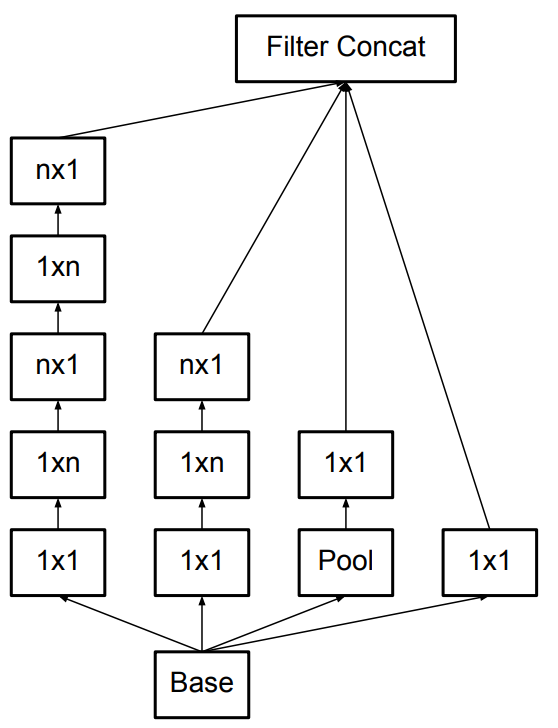
> **Figure 6.** Inception modules after the factorization of the n × n convolutions. In our proposed architecture, we chose n = 7 for the 17 × 17 grid. (The filter sizes are picked using principle 3)

In [14]:
class InceptionBlock_B(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.sub_layer_1 = nn.Sequential(
            BasicConv2d(in_channels=in_channels,  out_channels=64,  kernel_size=1,     stride=1, padding=0),
            BasicConv2d(in_channels=64,           out_channels=96,  kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(in_channels=96,           out_channels=128, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(in_channels=128,          out_channels=192, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(in_channels=192,          out_channels=192, kernel_size=(7,1), stride=1, padding=(3,0)),
        )
        self.sub_layer_2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=64,  kernel_size=1,     stride=1, padding=0),
            BasicConv2d(in_channels=64,          out_channels=96,  kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(in_channels=96,          out_channels=192, kernel_size=(7,1), stride=1, padding=(3,0)),
        )
        self.sub_layer_3 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels=in_channels, out_channels=192, kernel_size=1, stride=1, padding=0),
        )
        self.sub_layer_4 = BasicConv2d(in_channels=in_channels, out_channels=192, kernel_size=1, stride=1, padding=0)

    
    def forward(self, x):
        outputs = [
            self.sub_layer_1(x),
            self.sub_layer_2(x),
            self.sub_layer_3(x),
            self.sub_layer_4(x)
        ]

        return torch.cat(outputs, 1)
    
    
# rnd = torch.rand(1, 768, 17, 17)
# temp = InceptionBlock_B(in_channels=768)
# temp(rnd).shape    

## Inception Block "C"
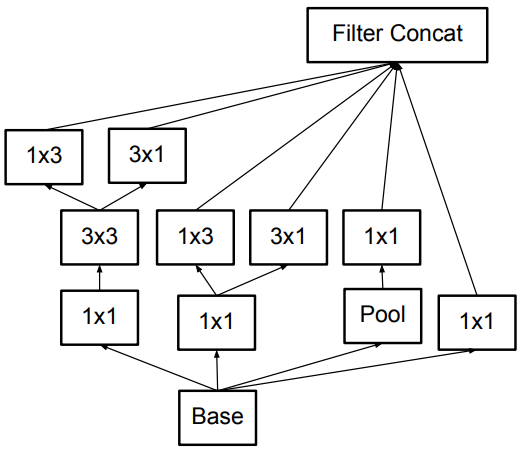
>**Figure 7.** Inception modules with expanded the filter bank outputs. This architecture is used on the coarsest (8 × 8) grids to promote high dimensional representations, as suggested by principle 2 of Section 2. We are using this solution only on the coarsest grid, since that is the place where producing high dimensional sparse representation is the most critical as the ratio of local processing (by 1 × 1 convolutions) is increased compared to the spatial aggregation.

In [15]:
class InceptionBlock_C(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        
        self.sub_layer_1_1 = BasicConv2d(in_channels=in_channels, out_channels=448, kernel_size=1)
        self.sub_layer_1_2 = BasicConv2d(in_channels=448,         out_channels=384, kernel_size=3,      padding=1)
        self.sub_layer_1_3 = BasicConv2d(in_channels=384,         out_channels=384, kernel_size=(1, 3), padding=(0, 1))
        self.sub_layer_1_4 = BasicConv2d(in_channels=384,         out_channels=384, kernel_size=(3, 1), padding=(1, 0))
        
        self.sub_layer_2_1 = BasicConv2d(in_channels=in_channels, out_channels=384, kernel_size=1)
        self.sub_layer_2_2 = BasicConv2d(in_channels=384,         out_channels=384, kernel_size=(1, 3), padding=(0, 1))
        self.sub_layer_2_3 = BasicConv2d(in_channels=384,         out_channels=384, kernel_size=(3, 1), padding=(1, 0))
        
        self.sub_layer_3_1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.sub_layer_3_2 = BasicConv2d(in_channels=in_channels, out_channels=192, kernel_size=1)
        
        self.sub_layer_4   = BasicConv2d(in_channels=in_channels, out_channels=320, kernel_size=1)
        
        
    def forward(self, x):
        first_result = self.sub_layer_1_1(x)
        first_result = self.sub_layer_1_2(first_result)
        first_result_1 = self.sub_layer_1_3(first_result)
        first_result_2 = self.sub_layer_1_4(first_result)
        
        second_result = self.sub_layer_2_1(x)
        second_result_1 = self.sub_layer_2_2(second_result)
        secind_result_2 = self.sub_layer_2_3(second_result)
        
        third_result = self.sub_layer_3_1(x)
        third_result = self.sub_layer_3_2(third_result)
        
        fourth_result = self.sub_layer_4(x)
        
        outputs = [
            first_result_1,
            first_result_2,
            second_result_1,
            secind_result_2,
            third_result,
            fourth_result
        ]

        return torch.cat(outputs, 1)
    
# rnd = torch.rand(1, 1280, 8, 8)
# temp = InceptionBlock_C(in_channels=1280)
# temp(rnd).shape         

## Inception Block "Reducer"

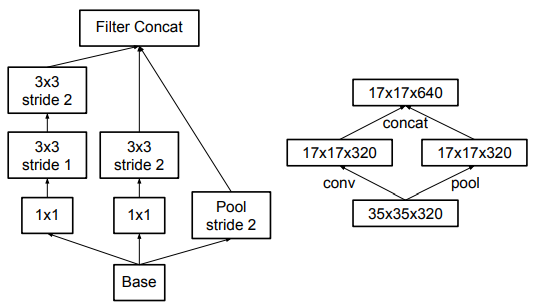
> **Figure 10.** Inception module that reduces the grid-size while expands the filter banks. It is both cheap and avoids the representational bottleneck as is suggested by principle 1. The diagram on the right represents the same solution but from the perspective of grid sizes rather than the operations.

In [16]:
class InceptionBlock_Reducer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.sub_layer_1 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1, padding=1),
            BasicConv2d(in_channels=64,          out_channels=96, kernel_size=3, stride=1, padding=0),
            BasicConv2d(in_channels=96,          out_channels=out_channels, kernel_size=3, stride=2, padding=0),
        )
        
        self.sub_layer_2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=64, kernel_size=1, stride=1, padding=0),
            BasicConv2d(in_channels=64,          out_channels=out_channels, kernel_size=3, stride=2, padding=0),
        )
        
        self.sub_layer_3 = nn.AvgPool2d(kernel_size=3, stride=2, padding=0)
        
    def forward(self, x):
        outputs = [
            self.sub_layer_1(x),
            self.sub_layer_2(x),
            self.sub_layer_3(x),
        ]

        return torch.cat(outputs, 1)
        
# rnd = torch.rand(1, 288, 35, 35)
# temp = InceptionBlock_Reducer(in_channels=288, out_channels=256)
# print(temp(rnd).shape)

# rnd = torch.rand(1, 768, 17, 17)
# temp = InceptionBlock_Reducer(in_channels=768, out_channels=256)
# print(temp(rnd).shape)

---

In [17]:
class Inception_v3(nn.Module):
    def __init__(self, num_classes: int = 6):
        super().__init__()
        self.initial_convs = nn.Sequential(
            BasicConv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0),
            BasicConv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
            BasicConv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            BasicConv2d(in_channels=64, out_channels=80, kernel_size=3, stride=1, padding=0),
            BasicConv2d(in_channels=80, out_channels=192, kernel_size=3, stride=2, padding=0),
            BasicConv2d(in_channels=192, out_channels=288, kernel_size=3, stride=1, padding=1)
        )
        
        self.inceptions_a = nn.Sequential(
            InceptionBlock_A(in_channels=288),
            InceptionBlock_A(in_channels=288),
            InceptionBlock_A(in_channels=288)
        )
        
        self.first_reduction = InceptionBlock_Reducer(in_channels=288, out_channels=240)
        
        self.inceptions_b = nn.Sequential(
            InceptionBlock_B(in_channels=768),
            InceptionBlock_B(in_channels=768),
            InceptionBlock_B(in_channels=768),
            InceptionBlock_B(in_channels=768),
            InceptionBlock_B(in_channels=768)
        )
        
        self.second_reduction = InceptionBlock_Reducer(in_channels=768, out_channels=256)
        
        self.inceptions_c = nn.Sequential(
            InceptionBlock_C(in_channels=1280),
            InceptionBlock_C(in_channels=2048)       
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flat = nn.Flatten()
        self.fc = nn.Linear(in_features=2048, out_features=num_classes)
        
    def forward(self, x: torch.Tensor):
        x = self.initial_convs(x)
        x = self.inceptions_a(x)
        x = self.first_reduction(x)
        x = self.inceptions_b(x)
        x = self.second_reduction(x)
        x = self.inceptions_c(x)
        x = self.avgpool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x

In [18]:
my_model = Inception_v3().to(device)

max_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(my_model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-8)
history = train(my_model, optimizer, criterion, max_epochs, train_dataloader, test_dataloader)

* Epoch 100/100
loss: 0.021, f1: 0.993, accuracy: 0.993, time 217.579
vall loss: 0.597, vall f1: 0.887, vall accuracy: 0.887


# Model loss

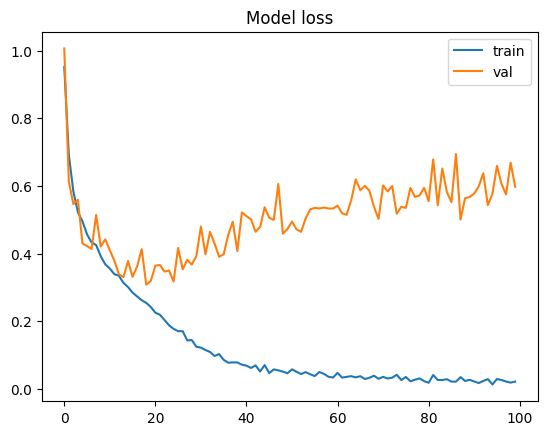

In [19]:
plt.plot(history['train']['loss'], label='train')
plt.plot(history['val']['loss'], label='val')
plt.legend()
plt.title('Model loss');

# Model metrics

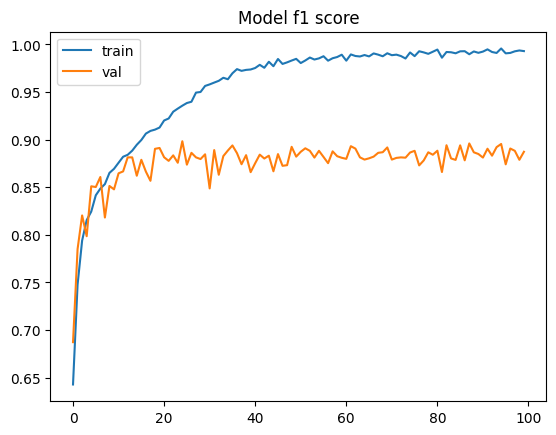

In [20]:
plt.plot(history['train']['score_f1'], label='train')
plt.plot(history['val']['score_f1'], label='val')
plt.legend()
plt.title('Model f1 score');

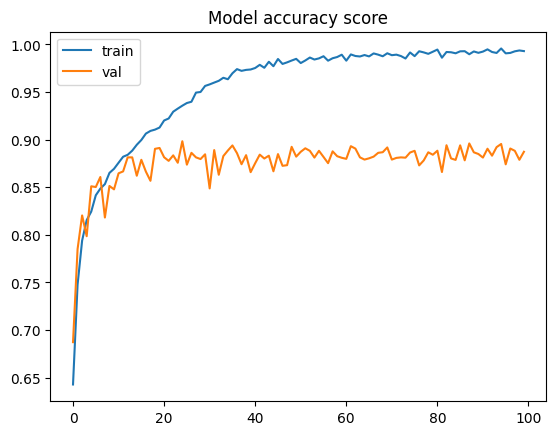

In [21]:
plt.plot(history['train']['score_acc'], label='train')
plt.plot(history['val']['score_acc'], label='val')
plt.legend()
plt.title('Model accuracy score');

# Testing model

In [22]:
avg_f1, avg_acc = calculate_metrics(test_dataloader, my_model)
print(f'Test f1 score : {avg_f1:.3f}')
print(f'Test accuracy score : {avg_acc:.3f}')

Test f1 score : 0.887
Test accuracy score : 0.887


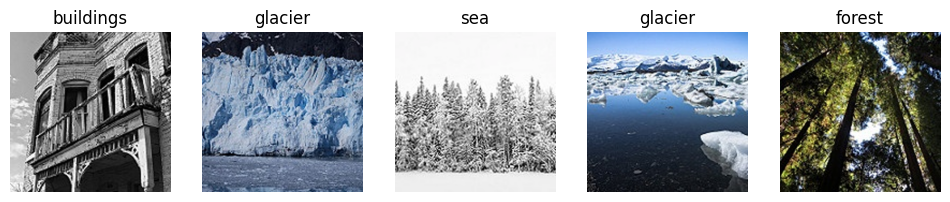

In [23]:
my_model.eval()
first_batch_pred = torch.argmax(my_model(first_test_batch[0].to(device)), 1).detach().cpu()
show_random_images(first_test_batch[0], first_batch_pred, full_dataset.classes)